## Setup

In [1]:
!pip install bert-for-tf2

     |████████████████████████████████| 41 kB 134 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30536 sha256=741a799c9420c70ebcd8536e6b126e7615663c1a9bf4dfc96bbd289c35047364
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19471 sha256=44b1833f7066d6dc2458d6acc117fd485e5969e40abec3d1dbb64d82fd333096
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7910 sha256=aad7d72237df5a88ee869ce67d07bcd03c8a052c48d4d4c720e758a774f3579a
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


In [2]:
import pandas as pd
import numpy as np
import json
import re
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score

In [3]:
import tensorflow as tf
import transformers
import bert 
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer 
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint

## Load Dataset
Train / Validation / Test = 7 / 1 / 2

In [4]:
df_train = pd.read_csv('../input/imdb-dataset/train.csv', usecols = ['review','sentiment'])
df_val = pd.read_csv('../input/imdb-dataset/val.csv', usecols = ['review','sentiment'])
df_test = pd.read_csv('../input/imdb-dataset/test.csv', usecols = ['review','sentiment'])

In [5]:
print(df_train.info())
df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     35000 non-null  object
 1   sentiment  35000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 547.0+ KB
None


,review,sentiment
0,"Having avoided seeing the movie in the cinema,...",0
1,With this movie I was really hoping that the i...,0
2,Raymond Burr stars as an attorney caught up in...,0
3,A lot people get hung up on this films tag as ...,1
4,I was a fan of Buffy and hoped it would come t...,0
...,...,...
34995,This is one creepy underrated Gem with chillin...,1
34996,The final chapter in the Hanzo the Razor trilo...,1
34997,"I just saw this movie and all I can say is, wh...",0
34998,Cameron Diaz is a woman who is married to a ju...,0


In [6]:
print(df_val.info())
df_val

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB
None


,review,sentiment
0,"A genuinely odd, surreal jumble of visual idea...",0
1,"""The Snow Queen"" is based on the famous and ve...",0
2,The quintessential Georgian film of Georgi Dan...,1
3,I'm a huge comedy show fan. Racial humor is al...,0
4,Pretty good film from Preminger; labyrinthine ...,1
...,...,...
4995,On Halloween a town is terrorized by a lunatic...,0
4996,This has to be one of the funniest movies I've...,1
4997,If I had realized John Wayne was in this movie...,0
4998,"I am right now in front of the tv, watching Ca...",1


In [7]:
print(df_test.info())
df_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None


,review,sentiment
0,I really liked this Summerslam due to the look...,1
1,Not many television shows appeal to quite as m...,1
2,The film quickly gets to a major chase scene w...,0
3,Jane Austen would definitely approve of this o...,1
4,Expectations were somewhat high for me when I ...,0
...,...,...
9995,Although Casper van Dien and Michael Rooker ar...,0
9996,I liked this movie. I wasn't really sure what ...,1
9997,Yes non-Singaporean's can't see what's the big...,1
9998,"As far as films go, this is likable enough. En...",0


## Metrics

In [8]:
def get_metrics(y_test, y_pred_proba):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred_proba >= 0.5), 4))
    print('F1_SCORE: ', round(f1_score(y_test, y_pred_proba >= 0.5, average = "macro"), 4))
    print('ROC_AUC_SCORE: ', round(roc_auc_score(y_test, y_pred_proba), 4))
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred_proba >= 0.5),'\n')

## Data Cleaning
Ref: https://www.kaggle.com/colearninglounge/nlp-data-preprocessing-and-cleaning

In [9]:
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

df_train['review'] = df_train['review'].apply(lambda z: remove_punctuations(z))
df_train['review'] = df_train['review'].apply(lambda z: remove_html(z))
df_train['review'] = df_train['review'].apply(lambda z: remove_url(z))
df_train['review'] = df_train['review'].apply(lambda z: remove_emoji(z))

df_val['review'] = df_val['review'].apply(lambda z: remove_punctuations(z))
df_val['review'] = df_val['review'].apply(lambda z: remove_html(z))
df_val['review'] = df_val['review'].apply(lambda z: remove_url(z))
df_val['review'] = df_val['review'].apply(lambda z: remove_emoji(z))

df_test['review'] = df_test['review'].apply(lambda z: remove_punctuations(z))
df_test['review'] = df_test['review'].apply(lambda z: remove_html(z))
df_test['review'] = df_test['review'].apply(lambda z: remove_url(z))
df_test['review'] = df_test['review'].apply(lambda z: remove_emoji(z))

In [10]:
def remove_abb(data):
    data = re.sub(r"he's", "he is", data)
    data = re.sub(r"there's", "there is", data)
    data = re.sub(r"We're", "We are", data)
    data = re.sub(r"That's", "That is", data)
    data = re.sub(r"won't", "will not", data)
    data = re.sub(r"they're", "they are", data)
    data = re.sub(r"Can't", "Cannot", data)
    data = re.sub(r"wasn't", "was not", data)
    data = re.sub(r"don\x89Ûªt", "do not", data)
    data= re.sub(r"aren't", "are not", data)
    data = re.sub(r"isn't", "is not", data)
    data = re.sub(r"What's", "What is", data)
    data = re.sub(r"haven't", "have not", data)
    data = re.sub(r"hasn't", "has not", data)
    data = re.sub(r"There's", "There is", data)
    data = re.sub(r"He's", "He is", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"You're", "You are", data)
    data = re.sub(r"I'M", "I am", data)
    data = re.sub(r"shouldn't", "should not", data)
    data = re.sub(r"wouldn't", "would not", data)
    data = re.sub(r"i'm", "I am", data)
    data = re.sub(r"I\x89Ûªm", "I am", data)
    data = re.sub(r"I'm", "I am", data)
    data = re.sub(r"Isn't", "is not", data)
    data = re.sub(r"Here's", "Here is", data)
    data = re.sub(r"you've", "you have", data)
    data = re.sub(r"you\x89Ûªve", "you have", data)
    data = re.sub(r"we're", "we are", data)
    data = re.sub(r"what's", "what is", data)
    data = re.sub(r"couldn't", "could not", data)
    data = re.sub(r"we've", "we have", data)
    data = re.sub(r"it\x89Ûªs", "it is", data)
    data = re.sub(r"doesn\x89Ûªt", "does not", data)
    data = re.sub(r"It\x89Ûªs", "It is", data)
    data = re.sub(r"Here\x89Ûªs", "Here is", data)
    data = re.sub(r"who's", "who is", data)
    data = re.sub(r"I\x89Ûªve", "I have", data)
    data = re.sub(r"y'all", "you all", data)
    data = re.sub(r"can\x89Ûªt", "cannot", data)
    data = re.sub(r"would've", "would have", data)
    data = re.sub(r"it'll", "it will", data)
    data = re.sub(r"we'll", "we will", data)
    data = re.sub(r"wouldn\x89Ûªt", "would not", data)
    data = re.sub(r"We've", "We have", data)
    data = re.sub(r"he'll", "he will", data)
    data = re.sub(r"Y'all", "You all", data)
    data = re.sub(r"Weren't", "Were not", data)
    data = re.sub(r"Didn't", "Did not", data)
    data = re.sub(r"they'll", "they will", data)
    data = re.sub(r"they'd", "they would", data)
    data = re.sub(r"DON'T", "DO NOT", data)
    data = re.sub(r"That\x89Ûªs", "That is", data)
    data = re.sub(r"they've", "they have", data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"should've", "should have", data)
    data = re.sub(r"You\x89Ûªre", "You are", data)
    data = re.sub(r"where's", "where is", data)
    data = re.sub(r"Don\x89Ûªt", "Do not", data)
    data = re.sub(r"we'd", "we would", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"weren't", "were not", data)
    data = re.sub(r"They're", "They are", data)
    data = re.sub(r"Can\x89Ûªt", "Cannot", data)
    data = re.sub(r"you\x89Ûªll", "you will", data)
    data = re.sub(r"I\x89Ûªd", "I would", data)
    data = re.sub(r"let's", "let us", data)
    data = re.sub(r"it's", "it is", data)
    data = re.sub(r"can't", "cannot", data)
    data = re.sub(r"don't", "do not", data)
    data = re.sub(r"you're", "you are", data)
    data = re.sub(r"i've", "I have", data)
    data = re.sub(r"that's", "that is", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"doesn't", "does not",data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"didn't", "did not", data)
    data = re.sub(r"ain't", "am not", data)
    data = re.sub(r"you'll", "you will", data)
    data = re.sub(r"I've", "I have", data)
    data = re.sub(r"Don't", "do not", data)
    data = re.sub(r"I'll", "I will", data)
    data = re.sub(r"I'd", "I would", data)
    data = re.sub(r"Let's", "Let us", data)
    data = re.sub(r"you'd", "You would", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"Ain't", "am not", data)
    data = re.sub(r"Haven't", "Have not", data)
    data = re.sub(r"Could've", "Could have", data)
    data = re.sub(r"youve", "you have", data)  
    data = re.sub(r"donå«t", "do not", data)  
    return data
    
df_train['review'] = df_train['review'].apply(lambda z: remove_abb(z))
df_val['review'] = df_val['review'].apply(lambda z: remove_abb(z))
df_test['review'] = df_test['review'].apply(lambda z: remove_abb(z))

In [11]:
print(df_train.shape)
print(df_train.head(5))
print(df_val.shape)
print(df_val.head(5))
print(df_test.shape)
print(df_test.head(5))

(35000, 2)
                                              review  sentiment
0  Having avoided seeing the movie in the cinema ...          0
1  With this movie I was really hoping that the i...          0
2  Raymond Burr stars as an attorney caught up in...          0
3  A lot people get hung up on this films tag as ...          1
4  I was a fan of Buffy and hoped it would come t...          0
(5000, 2)
                                              review  sentiment
0  A genuinely odd surreal jumble of visual ideas...          0
1  The Snow Queen is based on the famous and very...          0
2  The quintessential Georgian film of Georgi Dan...          1
3  Im a huge comedy show fan Racial humor is alwa...          0
4  Pretty good film from Preminger labyrinthine a...          1
(10000, 2)
                                              review  sentiment
0  I really liked this Summerslam due to the look...          1
1  Not many television shows appeal to quite as m...          1
2  The f

## Encoding 

In [12]:
class IntentDetectionData:
    DATA_COLUMN,  LABEL_COLUMN  = "review","sentiment"

    def __init__(self, train, val, test, tokenizer: FullTokenizer, classes, max_seq_len):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        ((self.train_x, self.train_y), (self.val_x, self.val_y), (self.test_x, self.test_y)) = map(self._prepare, [train, val, test])

        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.val_x, self.test_x = map(self._pad, [self.train_x, self.val_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
    
        for non, row in tqdm(df.iterrows()):
            text, label =\
                row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]

            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"] ## Tokens beigning and ending specified by separation of tokens.

            token_ids = self.tokenizer.convert_tokens_to_ids(tokens) ## Convert Tokens to IDs

            self.max_seq_len = max(self.max_seq_len, len(token_ids))

            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)] ## -2 as ignoring tokens provided by bert
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids)) ## padding by zeros
            x.append(np.array(input_ids))
        
        return np.array(x)

## Model

### LSTM

In [13]:
def LSTM_V0(bert_output):
    #...
    return outputs

### CNN

In [14]:
def CNN_V0(bert_output):
    net = Conv1D(128, 7, activation='relu',padding='same')(bert_output)
    net = MaxPooling1D()(net)
    net = Conv1D(256, 5, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(512, 3, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Flatten()(net)
    net = Dense(128, activation='relu')(net)
    net = Dropout(0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

### BiLSTM

In [15]:
def BiLSTM_V0(bert_output):
    net = Bidirectional(LSTM(units=32, return_sequences=True,))(bert_output)
    net = GlobalAveragePooling1D()(net)
    net = Dense(20, activation='relu')(net)
    net = Dropout(rate=0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

### CNN + LSTM

In [16]:
def CNN_LSTM_V0(bert_output):
    net = Dropout(0.3)(bert_output)
    net = Conv1D(200, 5, activation='relu')(net)
    net = MaxPooling1D(pool_size=2)(net)
    net = LSTM(100)(net)
    net = Dropout(0.3)(net)
    net = Dense(16,activation='relu')(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net)
    return outputs

In [17]:
def CNN_LSTM_V1(bert_output):

    # channel 1
    net = Conv1D(filters=128, kernel_size=3*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    a = LSTM(128)(net)

    # channel 2
    net = Conv1D(filters=128, kernel_size=5*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    b = LSTM(128)(net)

    # channel 3
    net = Conv1D(filters=128, kernel_size=7*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    c = LSTM(128)(net)

    # channel 4
    net = Conv1D(filters=128, kernel_size=9*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    d = LSTM(128)(net)

    merged = concatenate([a,b,c,d])
    dense = Dense(100, activation='relu')(merged)
    drop = Dropout(0.2)(dense)
    outputs = Dense(1, activation='sigmoid')(merged)
    return outputs

### LSTM + CNN

In [18]:
def LSTM_CNN_V0(bert_output):
    net = Bidirectional(LSTM(128, return_sequences=True))(bert_output)
    net = Conv1D(128, 7, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(256, 5, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(512, 3, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Flatten()(net)
    net = Dense(128, activation='relu')(net)
    net = Dropout(0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

### Choose model

In [19]:
def create_model(model_name, model_ver, max_seq_len, bert_checkpnt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read()) ## Reading bert config
        bert_params = map_stock_config_to_params(bc) ## Mapping parameters 
        bert_params.adapter_size = None # Adapter size helps tune Bert model faster
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    ## Creat dictionary
    choose_model = {'LSTM':{},
                    'CNN':{0: CNN_V0},
                    'BiLSTM':{0: BiLSTM_V0},
                    'CNN+LSTM':{0: CNN_LSTM_V0, 1: CNN_LSTM_V1},
                    'LSTM+CNN':{0: LSTM_CNN_V0},}
    
    ## Specifying input
    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)
        
    outputs = choose_model[model_name][model_ver](bert_output)

    model = keras.Model(input_ids, outputs)
    model.build(input_shape=(None, max_seq_len))
    load_stock_weights(bert, bert_checkpnt_file) ##Loading the weights from bert chckpoint file
        
    return model

## BERT model

In [20]:
# Load BERT model
# https://github.com/google-research/bert/blob/master/README.md

bert_model_name = "uncased_L-12_H-768_A-12"
# uncased_L-4_H-512_A-8
# uncased_L-12_H-768_A-12

!wget  https://storage.googleapis.com/bert_models/2020_02_20/{bert_model_name}.zip
!unzip {bert_model_name}.zip

--2024-11-12 09:57:36--  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.207, 142.251.31.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 408102251 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 389.20M  39.7MB/s    in 10s     

2024-11-12 09:57:46 (37.8 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [408102251/408102251]

Archive:  uncased_L-12_H-768_A-12.zip
  inflating: bert_model.ckpt.data-00000-of-00001  
  inflating: bert_config.json        
  inflating: vocab.txt               
  inflating: bert_model.ckpt.index   


In [21]:
bert_model_path = "./"
bert_checkpnt_file = os.path.join(bert_model_path, "bert_model.ckpt")
bert_config_file = os.path.join(bert_model_path, "bert_config.json")
bert_vocab_file = os.path.join(bert_model_path, "vocab.txt")
print(bert_checkpnt_file)
print(bert_config_file)
print(bert_vocab_file)

./bert_model.ckpt
./bert_config.json
./vocab.txt


## Data Pretrain

In [22]:
# Tokenize
tokenizer = FullTokenizer(vocab_file=bert_vocab_file)
tokens = tokenizer.tokenize("People say nothing is impossible, but I do nothing everyday")
print(tokens)
tokenizer.convert_tokens_to_ids(tokens)

['people', 'say', 'nothing', 'is', 'impossible', ',', 'but', 'i', 'do', 'nothing', 'everyday']


[2111, 2360, 2498, 2003, 5263, 1010, 2021, 1045, 2079, 2498, 10126]

In [23]:
classes = [0, 1]
max_seq_len = 384
data = IntentDetectionData(df_train, df_val, df_test, tokenizer, classes, max_seq_len)
print(data.max_seq_len)

35000it [03:53, 150.15it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
5000it [00:33, 149.65it/s]
10000it [01:06, 149.41it/s]


384


## Creat model

In [24]:
model_name = "LSTM+CNN"
model_ver = 0
LR = 2e-5
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=LR)
metrics = tf.metrics.BinaryAccuracy()

model = create_model(model_name, model_ver, max_seq_len, bert_checkpnt_file)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Done loading 196 BERT weights from: ./bert_model.ckpt into <bert.model.BertModelLayer object at 0x79248ccfe810> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 384)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 384, 768)          108890112 
____________________________________________

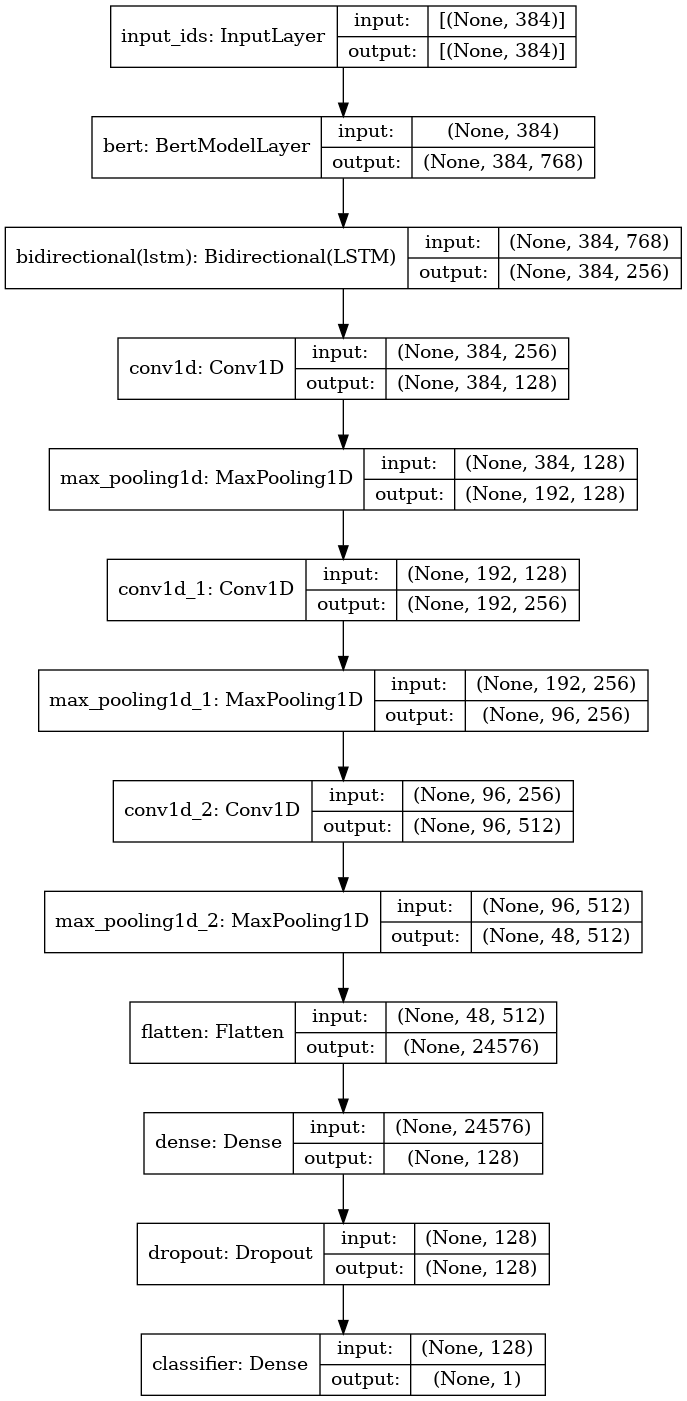

In [25]:
# Plot architecture model
tf.keras.utils.plot_model(model, show_shapes=True, dpi=96) #to_file='model.jpeg'

## Model training

In [26]:
# Save model
model_ckpt_path = f"[{bert_model_name}]{model_name}_V{model_ver}_{max_seq_len}.hdf5"
checkpoint = ModelCheckpoint(model_ckpt_path, monitor='val_binary_accuracy', mode='max',verbose=1, save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint]

# Training
print(f"Training model with {bert_model_name}_{model_name}_V{model_ver}_{max_seq_len}\n")
train_history = model.fit(data.train_x, data.train_y, validation_data=(data.val_x,data.val_y), epochs=3, batch_size=16, verbose=1, callbacks=callbacks_list)

Training model with uncased_L-12_H-768_A-12_LSTM+CNN_V0_384

Epoch 1/3
2188/2188 [==============================] - 2262s 1s/step - loss: 0.4304 - binary_accuracy: 0.7709 - val_loss: 0.1848 - val_binary_accuracy: 0.9286

Epoch 00001: val_binary_accuracy improved from -inf to 0.92860, saving model to [uncased_L-12_H-768_A-12]LSTM+CNN_V0_384.hdf5
Epoch 2/3
2188/2188 [==============================] - 2235s 1s/step - loss: 0.1553 - binary_accuracy: 0.9447 - val_loss: 0.2003 - val_binary_accuracy: 0.9276

Epoch 00002: val_binary_accuracy did not improve from 0.92860
Epoch 3/3
2188/2188 [==============================] - 2240s 1s/step - loss: 0.0798 - binary_accuracy: 0.9751 - val_loss: 0.2283 - val_binary_accuracy: 0.9286

Epoch 00003: val_binary_accuracy did not improve from 0.92860


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


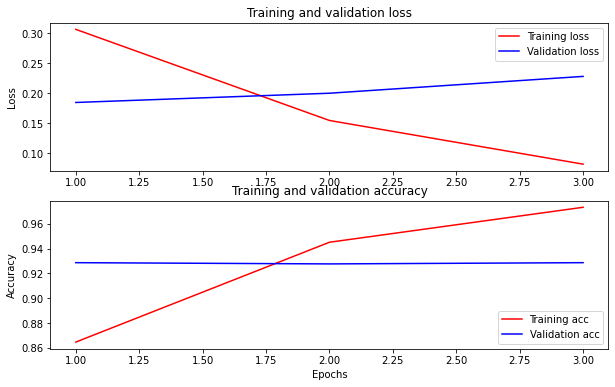

In [27]:
# Plot accuracy and loss
history_dict = train_history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [28]:
# Save architecture model
config = model.to_json()
model_config_path = f"[{bert_model_name}]{model_name}_V{model_ver}_{max_seq_len}.json"
with open(model_config_path, "w") as outfile:
    json.dump(config, outfile)

## Evaluate

In [29]:
model.load_weights(model_ckpt_path)
y_pred_proba = model.predict(data.test_x)
get_metrics(data.test_y, y_pred_proba)

ACCURACY_SCORE:  0.9227
F1_SCORE:  0.9226
ROC_AUC_SCORE:  0.9792
CONFUSION_MATRIX:
 [[4463  498]
 [ 275 4764]] 

